In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import urllib.request
import os
import shutil
from tqdm import tqdm
import numpy as np
import pandas as pd
from collections import defaultdict
from torchattacks import PGD
import torch
import os
import pickle
from collections import defaultdict
from tqdm import tqdm

In [5]:
def preprocess_image(image_path):
    """Preprocess the image: resize, crop, normalize, and convert to tensor."""
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0).requires_grad_(True)
    return image, input_tensor

def get_prediction(model, input_tensor):
    """Perform forward pass and return the predicted class index."""
    output = model(input_tensor)
    predicted_class = output.argmax().item()
    return output, predicted_class

def compute_gradients(model, input_tensor, predicted_class):
    """Compute gradients of the predicted class score w.r.t. input image."""
    model.zero_grad()
    output, _ = get_prediction(model, input_tensor)
    output[0, predicted_class].backward()
    return input_tensor.grad.data

def generate_saliency_map(gradients, absolute=True):
    """Generate saliency map. Use absolute values if absolute=True, else keep signed gradients."""
    if absolute:
        gradients = gradients.abs()
    saliency_map, _ = gradients.max(dim=1)
    saliency_map = saliency_map.squeeze().numpy()
    return saliency_map

def normalize_saliency_map(saliency_map, signed=False):
    """Normalize saliency map between 0-1 (for absolute) or -1 to 1 (for signed gradients)."""
    if signed:
        return saliency_map / (np.max(np.abs(saliency_map)) + 1e-8)
    else:
        return (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min() + 1e-8)

def visualize_combined_results(image, abs_saliency, signed_saliency):
    """Display original image, absolute saliency, and signed saliency in subplots"""
    plt.figure(figsize=(24, 7.5))
    
    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    # Absolute Saliency
    plt.subplot(1, 3, 2)
    heatmap = plt.imshow(abs_saliency, cmap='hot', vmin=0, vmax=1)
    plt.colorbar(heatmap, fraction=0.046, pad=0.04)
    plt.title("Absolute Saliency Map")
    plt.axis("off")

    # Signed Saliency
    plt.subplot(1, 3, 3)
    signed_heatmap = plt.imshow(signed_saliency, cmap='seismic', vmin=-1, vmax=1)
    plt.colorbar(signed_heatmap, fraction=0.046, pad=0.04)
    plt.title("Signed Saliency Map")
    plt.axis("off")

    plt.suptitle("Saliency map of input gradients w.r.t. the image's classification", fontsize=16)
    plt.tight_layout()
    plt.show()

def generate_heatmap(model, image_path):
    """Generate heatmap for the image at the given path."""
    image, input_tensor = preprocess_image(image_path)

    output, predicted_class = get_prediction(model, input_tensor)
    gradients = compute_gradients(model, input_tensor, predicted_class)

    abs_saliency = normalize_saliency_map(
        generate_saliency_map(gradients, absolute=True), 
        signed=False
    )
    signed_saliency = normalize_saliency_map(
        generate_saliency_map(gradients, absolute=False), 
        signed=True
    )

    visualize_combined_results(image, abs_saliency, signed_saliency)

In [6]:
model = models.resnet50(pretrained=True)
model = model.eval()

c:\Users\nasta\miniconda3\envs\adaexam\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nasta\miniconda3\envs\adaexam\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


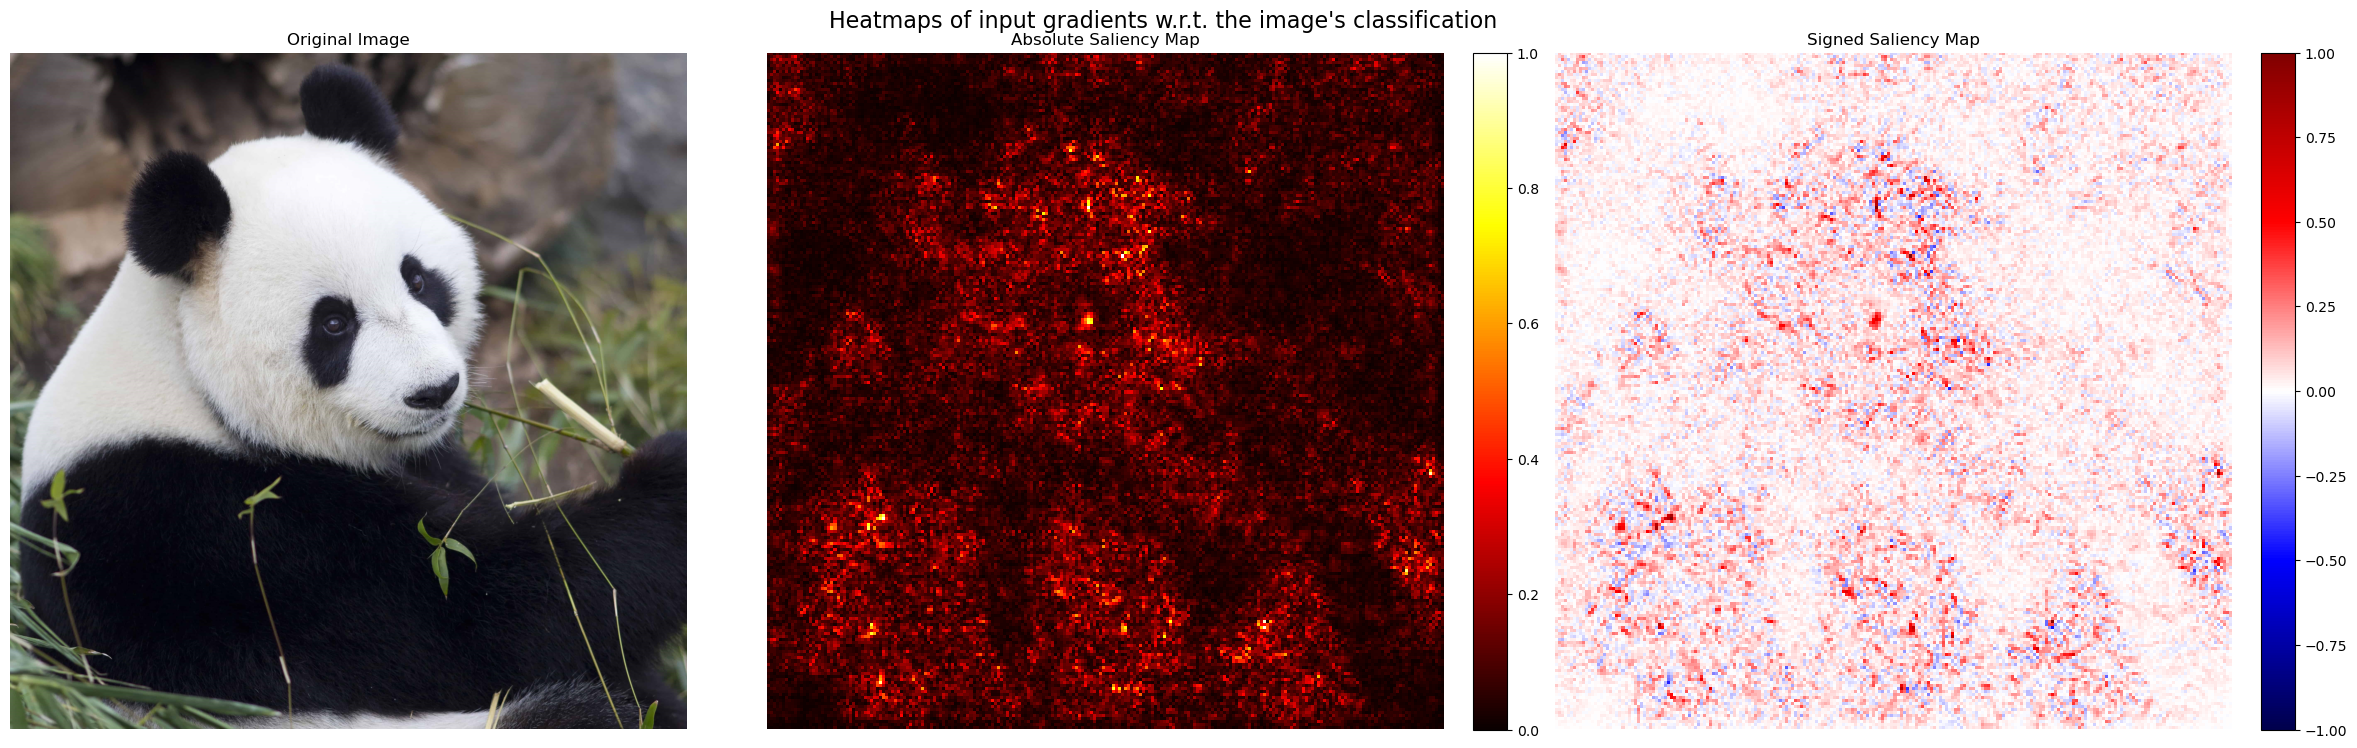

In [26]:
generate_heatmap(model, "Ressources/panda.jpg")

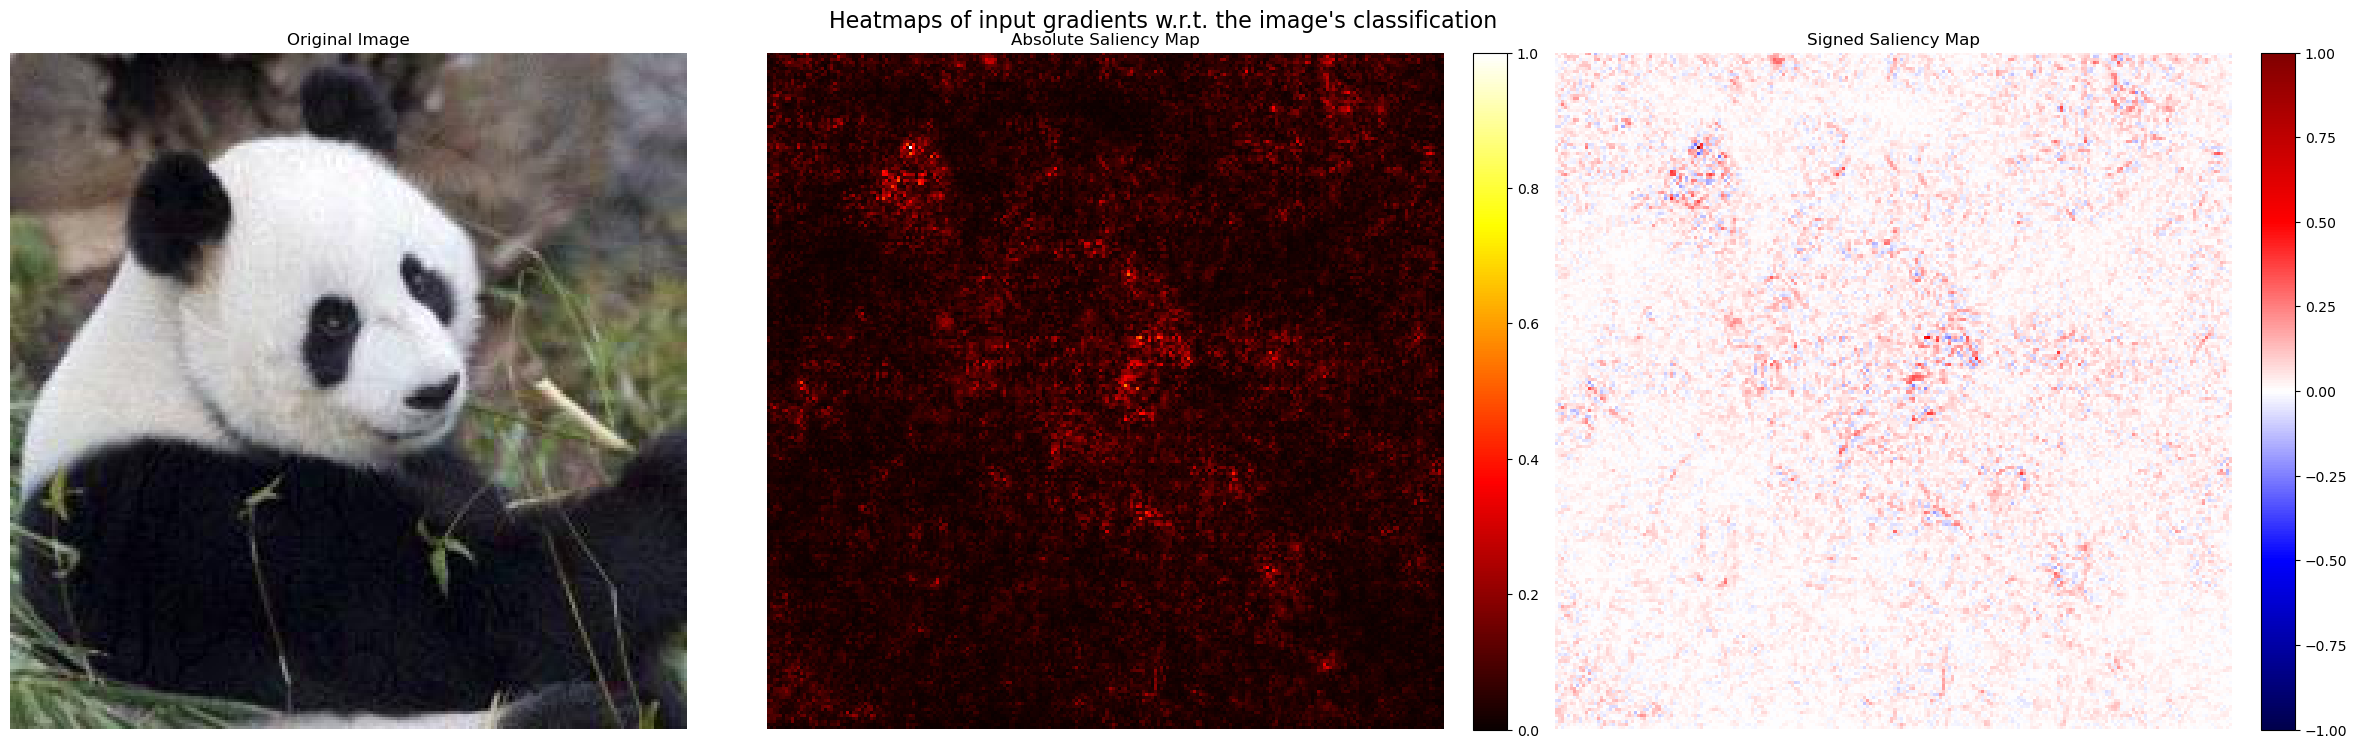

In [27]:
generate_heatmap(model, "output/panda_perturbed.jpg")

In [1]:
# Function to extract activations from specified layers in ResNet
def get_layer_activations2(model, images, target_layers):
    activations = {}

    def hook_fn(module, input, output, layer_name):
        # activation.shape -> [batch_size, num_channels, height, width]
        activations[layer_name] = output.detach().mean(dim=[2, 3])
        # activations[layer_name] = output.detach().amax(dim=[2, 3])

    hooks = []
    for name, layer in model.named_modules():
        if name in target_layers:
            hooks.append(layer.register_forward_hook(lambda m, i, o, n=name: hook_fn(m, i, o, n)))

    # Forward pass to store activations
    with torch.no_grad():
        model(images)

    # Remove hooks after use
    for hook in hooks:
        hook.remove()

    return activations

In [2]:
def show_top_neuron_images(model, target_layer, neuron_index, val_dir='./tiny-imagenet-200/val/images/'):
    # Preprocessing steps
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4802, 0.4481, 0.3975], std=[0.2302, 0.2265, 0.2262])
    ])
    
    # Load and preprocess images
    image_paths = [os.path.join(val_dir, f) for f in os.listdir(val_dir) 
                  if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
    images = [transform(Image.open(p).convert('RGB')) for p in image_paths]
    
    # Get activations with progress bar
    activations = []
    for img in tqdm(images, desc="Computing activations"):
        layer_acts = get_layer_activations2(model, img.unsqueeze(0), [target_layer])
        neuron_act = layer_acts[target_layer].flatten()[neuron_index].item()
        activations.append(neuron_act)
    
    # Display original images
    top_indices = np.argsort(activations)[-50:][::-1]
    plt.figure(figsize=(20, 10))
    
    # Denormalization parameters
    mean = torch.tensor([0.4802, 0.4481, 0.3975]).view(3, 1, 1)
    std = torch.tensor([0.2302, 0.2265, 0.2262]).view(3, 1, 1)
    
    for i, idx in enumerate(top_indices):
        plt.subplot(5, 10, i+1)
        # Reverse normalization
        denorm_img = torch.clamp(images[idx] * std + mean, 0, 1)
        plt.imshow(denorm_img.permute(1, 2, 0).numpy())
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Computing activations: 100%|██████████| 10100/10100 [10:26<00:00, 16.12it/s]


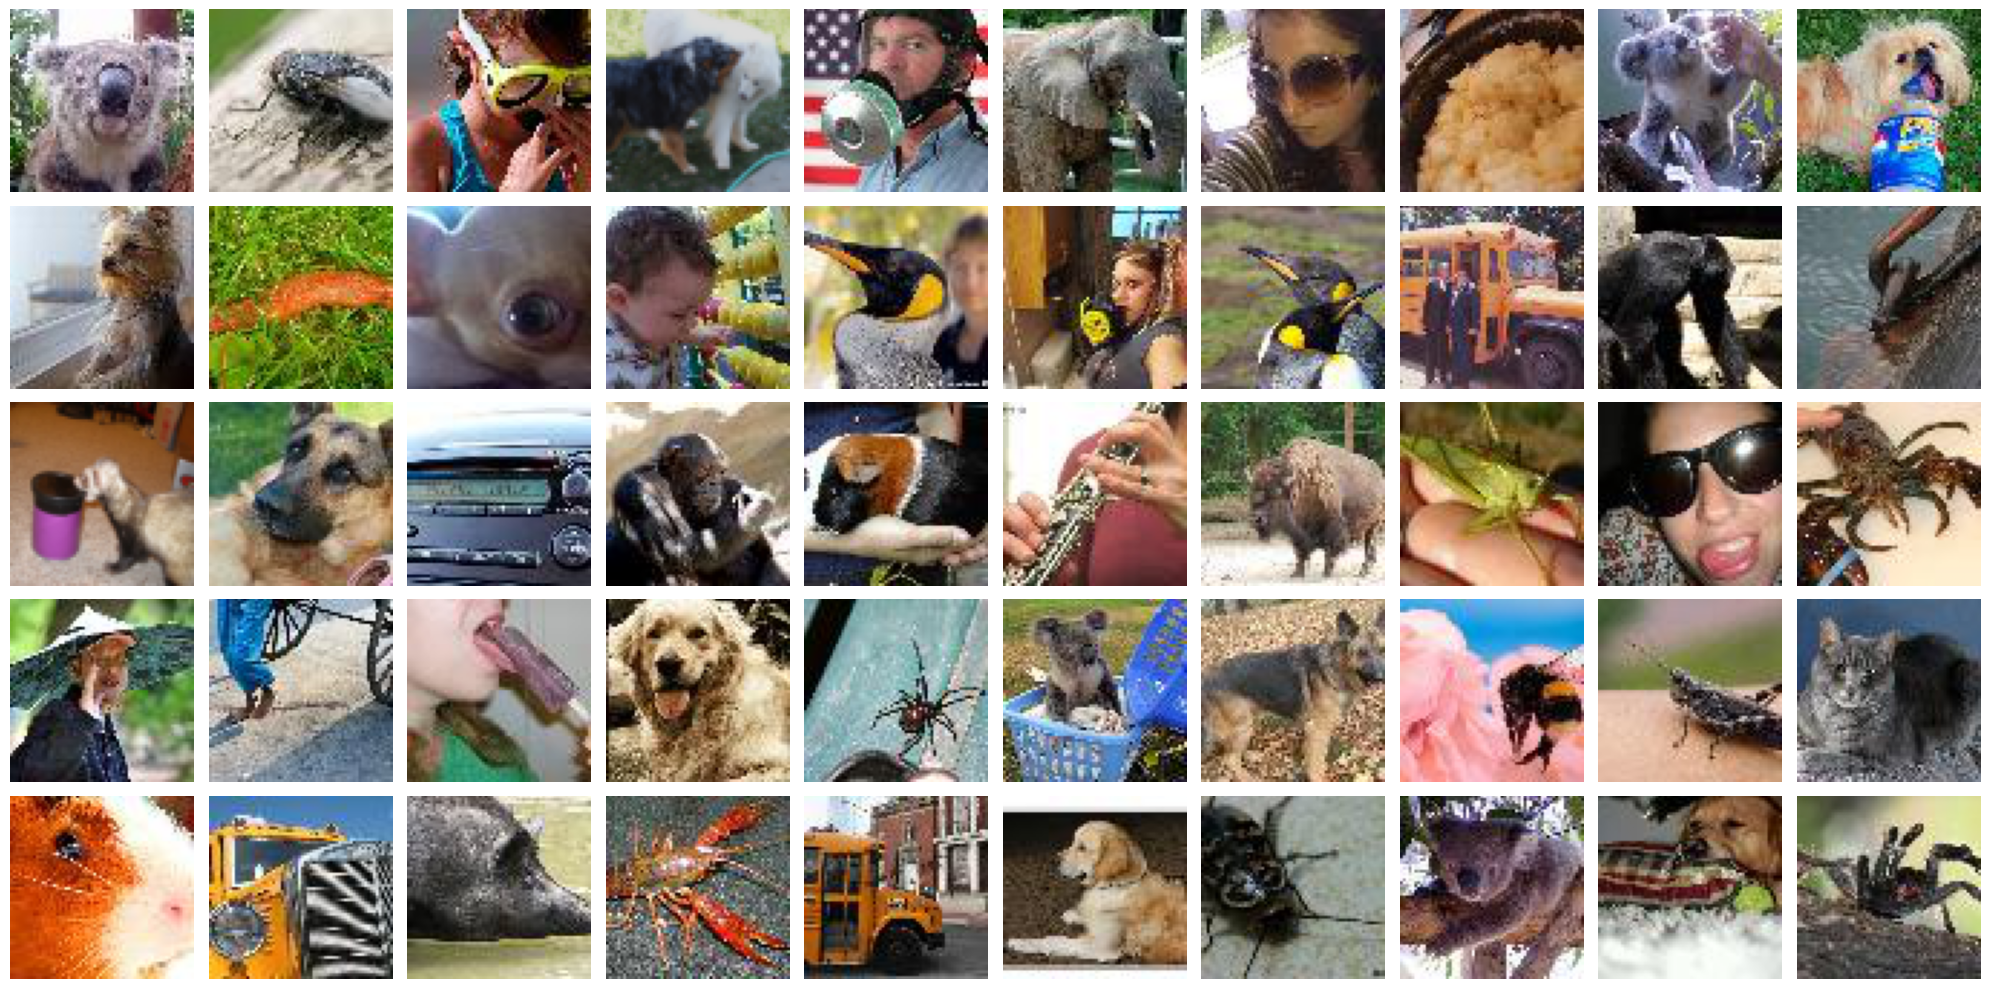

In [9]:
show_top_neuron_images(model, 'layer4.2.conv1', 495, val_dir='tiny-imagenet-200/images/images')

In [ ]:
def show_top_neuron_images(model, target_layer, neuron_index, val_dir='./tiny-imagenet-200/val/images/'):
    # Preprocessing steps
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4802, 0.4481, 0.3975], std=[0.2302, 0.2265, 0.2262])
    ])
    
    # Load and preprocess images
    image_paths = [os.path.join(val_dir, f) for f in os.listdir(val_dir) 
                  if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
    images = [transform(Image.open(p).convert('RGB')) for p in image_paths]
    
    # Get activations with progress bar
    activations = []
    for img in tqdm(images, desc="Computing activations"):
        layer_acts = get_layer_activations2(model, img.unsqueeze(0), [target_layer])
        neuron_act = layer_acts[target_layer].flatten()[neuron_index].item()
        activations.append(neuron_act)
    
    # Display original images and print paths
    top_indices = np.argsort(activations)[-50:][::-1]
    plt.figure(figsize=(20, 10))
    
    # Denormalization parameters
    mean = torch.tensor([0.4802, 0.4481, 0.3975]).view(3, 1, 1)
    std = torch.tensor([0.2302, 0.2265, 0.2262]).view(3, 1, 1)
    
    print("Top 50 image paths:")  # Added path printing
    for i, idx in enumerate(top_indices):
        print(image_paths[idx])  # Print each path
        plt.subplot(5, 10, i+1)
        # Reverse normalization
        denorm_img = torch.clamp(images[idx] * std + mean, 0, 1)
        plt.imshow(denorm_img.permute(1, 2, 0).numpy())
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Computing activations: 100%|██████████| 10100/10100 [08:22<00:00, 20.08it/s]


Top 50 image paths:
tiny-imagenet-200/images/images\val_1240.JPEG
tiny-imagenet-200/images/images\val_7491.JPEG
tiny-imagenet-200/images/images\val_2628.JPEG
tiny-imagenet-200/images/images\n02111889_1.JPEG
tiny-imagenet-200/images/images\val_5462.JPEG
tiny-imagenet-200/images/images\val_511.JPEG
tiny-imagenet-200/images/images\val_8846.JPEG
tiny-imagenet-200/images/images\val_2615.JPEG
tiny-imagenet-200/images/images\val_6578.JPEG
tiny-imagenet-200/images/images\val_8064.JPEG
tiny-imagenet-200/images/images\val_3091.JPEG
tiny-imagenet-200/images/images\val_5535.JPEG
tiny-imagenet-200/images/images\val_6125.JPEG
tiny-imagenet-200/images/images\val_3680.JPEG
tiny-imagenet-200/images/images\val_6981.JPEG
tiny-imagenet-200/images/images\val_7196.JPEG
tiny-imagenet-200/images/images\val_1073.JPEG
tiny-imagenet-200/images/images\val_6286.JPEG
tiny-imagenet-200/images/images\val_1421.JPEG
tiny-imagenet-200/images/images\val_9984.JPEG
tiny-imagenet-200/images/images\n02441942_10016.JPEG
tiny-

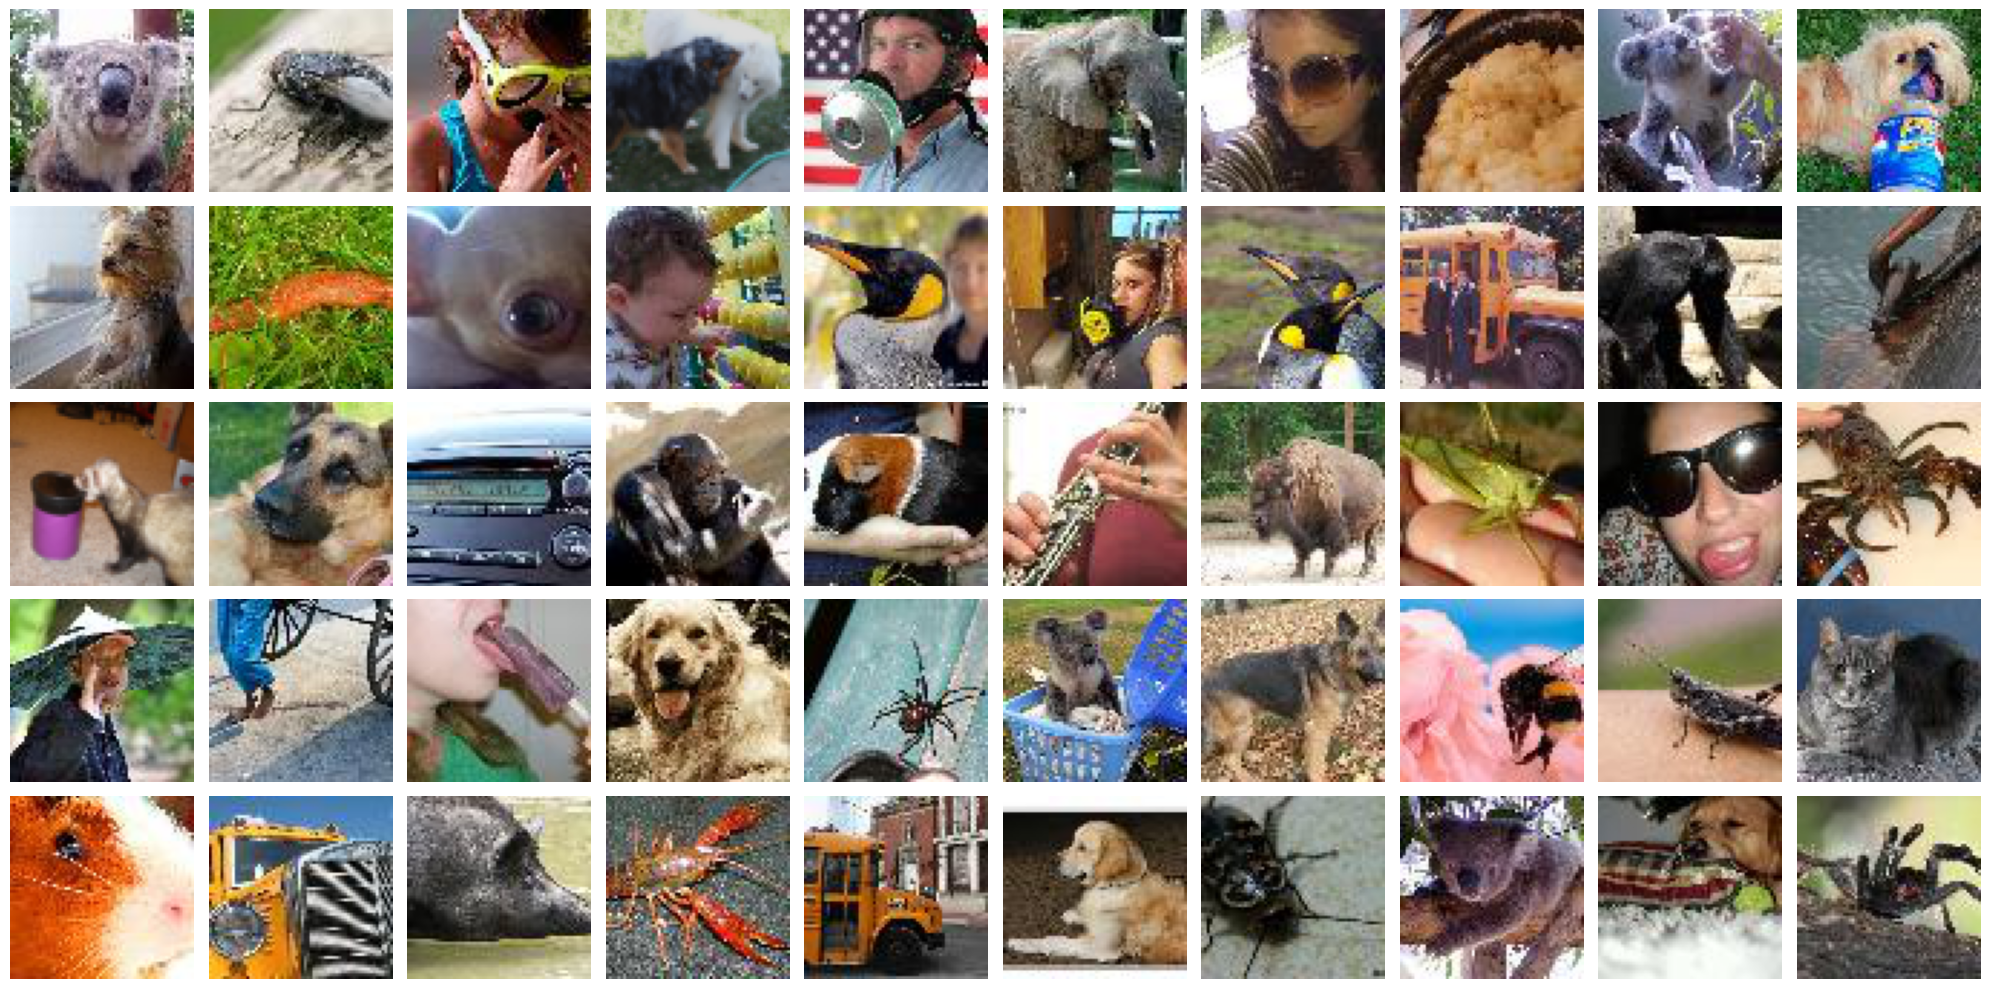

In [15]:
show_top_neuron_images(model, 'layer4.2.conv1', 495, val_dir='tiny-imagenet-200/images/images')